Inspriation: [Quelle](https://nzlul.medium.com/the-classification-of-text-messages-using-lstm-bi-lstm-and-gru-f79b207f90ad)<br>
Daten: [Quelle](https://github.com/kitsamho/songlyrics_univeral_sentence_encoder/tree/master/Lyric_data)


## Imports

In [1]:
#%conda install pip
# %pip install -r requirements.txt
# Load, explore and plot data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# Train test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional
from tensorflow.keras.utils import to_categorical


import nltk
from nltk.corpus import stopwords
import re

######## SEED setzen
import random
# Random Seed setzen:
SEED = 49
random.seed(SEED)
np.random.seed(SEED)



label_encoder = LabelEncoder()

## Load Data

In [2]:
load_df = pd.read_csv('preprocessed_single_label.csv', encoding='ISO-8859-1')
load_df.head(3)

,Unnamed: 0,Titel,Lyric,Artist,Genres
0,1719,I Miss Her,oh lord id like know thinks oh oh lord wanna g...,Olodum,AxÃ©
1,1766,They Don't Care About Us,skin head dead head everybody gone bad situati...,Olodum,AxÃ©
2,2586,Loved You Right Away,moment saw minute met wonderful feeling never ...,Carlinhos Brown,AxÃ©


Lyrics (Data) und Genere (Label) haben keinen Nullwert. Song (-Titel) fehelen 6 aber dass ist egal die können ignoriert werden.

In [3]:
# Assuming df is your DataFrame and 'Genres' is the column with genre names
load_df['Genres'] = load_df['Genres'].replace('Hip Hop', 'Rap')
# Conversion to string
load_df.loc[:, 'Titel'] = load_df['Titel'].astype(str)
load_df.loc[:, 'Lyric'] = load_df['Lyric'].astype(str)
load_df.loc[:, 'Artist'] = load_df['Artist'].astype(str)

# Analysis

In [4]:
num_samples = 500
num_genres = 20

analysis_df = load_df.dropna(subset=['Genres'])  # Remove any None entries if skipping

top_genres = analysis_df['Genres'].value_counts().nlargest(num_genres).index

# Filter the DataFrame to only include rows with the top five genres
analysis_df = analysis_df[analysis_df['Genres'].isin(top_genres)]

def sample_or_skip(group):
    return group.sample(n=num_samples, random_state=SEED) if len(group) >= num_samples else None

analysis_df = analysis_df.groupby('Genres').apply(sample_or_skip).reset_index(drop=True)


# Now df_top_genres contains only the rows where the genre is one of the top five
print(analysis_df['Genres'].value_counts())

Genres
Blues               500
Country             500
Tecnopop            500
Soft Rock           500
RomÃ¢ntico          500
Rockabilly          500
Rock                500
Reggae              500
Rap                 500
Punk Rock           500
Pop/Rock            500
Pop                 500
Jazz                500
Indie               500
Heavy Metal         500
Hard Rock           500
Gospel/Religioso    500
Folk                500
Electronica         500
Trilha Sonora       500
Name: count, dtype: int64


C:\Users\herbe\AppData\Local\Temp\ipykernel_2684\4267633767.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  analysis_df = analysis_df.groupby('Genres').apply(sample_or_skip).reset_index(drop=True)


In [9]:
# Count the number of words in the 'Lyric' column
analysis_df.loc[:, 'lyric_count'] = analysis_df['Lyric'].str.split().str.len()
# Calculate average lyric counts per genre
average_lyric_counts = analysis_df.groupby('Genres')['lyric_count'].mean()

print(average_lyric_counts.sort_values())

Genres
Jazz                 74.144
Indie                89.482
Gospel/Religioso     89.930
Rockabilly           90.192
Punk Rock            92.150
Heavy Metal          96.276
Blues                96.862
RomÃ¢ntico          100.074
Soft Rock           100.936
Folk                101.506
Country             108.488
Rock                109.980
Electronica         110.610
Tecnopop            114.082
Trilha Sonora       118.454
Hard Rock           120.758
Pop/Rock            123.952
Reggae              142.136
Pop                 149.790
Rap                 293.258
Name: lyric_count, dtype: float64


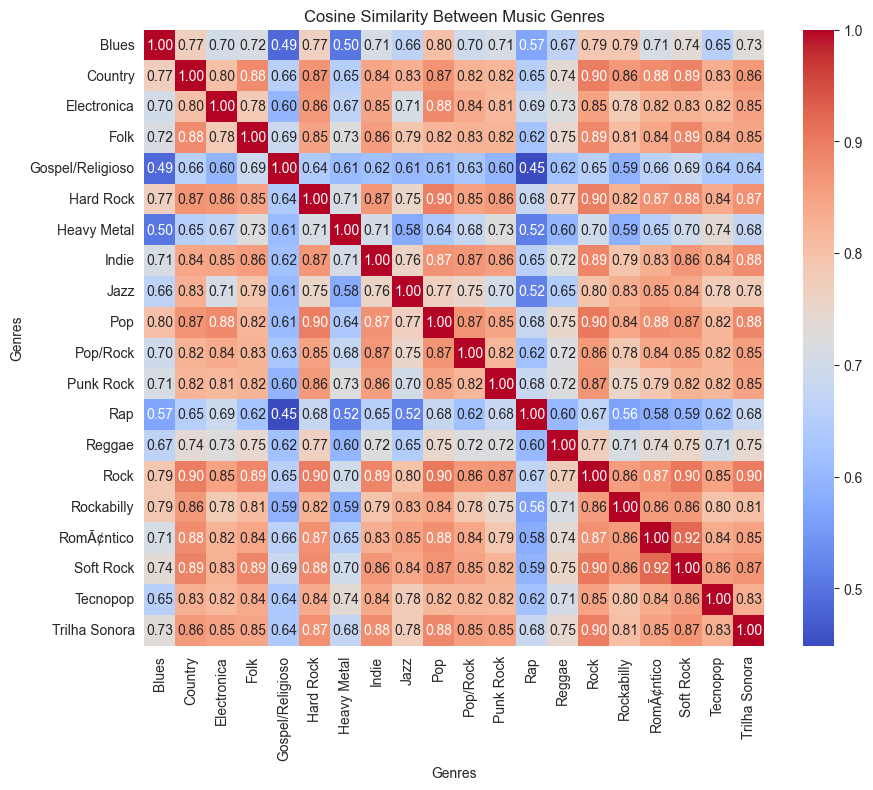

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Assuming df is a DataFrame with 'Lyrics' and 'Genres'
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(analysis_df['Lyric'])

# Create a DataFrame to hold genres and their TF-IDF vectors
genre_tfidf = pd.DataFrame(tfidf_matrix.toarray(), index=analysis_df['Genres'], columns=vectorizer.get_feature_names_out())

# Group by genre and calculate the mean TF-IDF score for each genre
mean_tfidf_by_genre = genre_tfidf.groupby('Genres').mean()

# Calculate the pairwise cosine similarity between genre vectors
similarity_matrix = cosine_similarity(mean_tfidf_by_genre)
similarity_df = pd.DataFrame(similarity_matrix, index=mean_tfidf_by_genre.index, columns=mean_tfidf_by_genre.index)

# Set the plot size
plt.figure(figsize=(10, 8))

# Create a heatmap to visualize the similarity matrix
sns.heatmap(similarity_df, 
            annot=True,   # Optionally add annotations to each cell
            fmt=".2f",    # Formatting the annotation if `annot` is True
            cmap='coolwarm',  # Color map style
            xticklabels=similarity_df.columns,  # Ensuring labels are genre names
            yticklabels=similarity_df.index)

# Add titles and labels for clarity
plt.title('Cosine Similarity Between Music Genres')
plt.xlabel('Genres')
plt.ylabel('Genres')

# Show the plot
plt.show()


In [48]:
from itertools import combinations

# Get all combinations of 5 genres
genre_combinations = list(combinations(similarity_df.index, 4))

# Function to calculate the mean similarity of a combination
def mean_similarity(combination):
    # Extract the sub-matrix of the similarity matrix for the given combination
    sub_matrix = similarity_df.loc[combination, combination]
    # Calculate the mean of the upper triangle of the matrix, excluding the diagonal
    mean_sim = np.mean([sub_matrix.iloc[i, j] for i in range(len(combination)) for j in range(i+1, len(combination))])
    return mean_sim

# Calculate mean similarity for each combination
mean_similarities = [(combo, mean_similarity(combo)) for combo in genre_combinations]

# Find the combination with the smallest mean similarity
min_similarity_combo = min(mean_similarities, key=lambda x: x[1])

print("Combination with the smallest mean similarity:", min_similarity_combo[0])
print("Mean similarity:", min_similarity_combo[1])

# Find the combination with the smallest mean similarity
max_similarity_combo = max(mean_similarities, key=lambda x: x[1])

print("Combination with the maximum mean similarity:", max_similarity_combo[0])
print("Mean similarity:", max_similarity_combo[1])

Combination with the smallest mean similarity: ('Blues', 'Gospel/Religioso', 'Heavy Metal', 'Rap')
Mean similarity: 0.5222022446916579
Combination with the maximum mean similarity: ('Country', 'Rock', 'RomÃ¢ntico', 'Soft Rock')
Mean similarity: 0.8944765686282835


In [49]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_tsne_for_genres(df, genre_subset, title_suffix):
    # Filter the DataFrame for the genres in genre_subset
    filtered_df = df[df['Genres'].isin(genre_subset)]
    
    # Vectorize the lyrics
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(filtered_df['Lyric'])
    # Reduce dimensions
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(X.toarray())
    
    filtered_df['tsne-2d-one'] = tsne_results[:,0]
    filtered_df['tsne-2d-two'] = tsne_results[:,1]

    # Calculate IQR for scaling axis
    Q1_tsne_one = np.percentile(filtered_df['tsne-2d-one'], 25)
    Q3_tsne_one = np.percentile(filtered_df['tsne-2d-one'], 75)
    IQR_tsne_one = Q3_tsne_one - Q1_tsne_one
    Q1_tsne_two = np.percentile(filtered_df['tsne-2d-two'], 25)
    Q3_tsne_two = np.percentile(filtered_df['tsne-2d-two'], 75)
    IQR_tsne_two = Q3_tsne_two - Q1_tsne_two

    # Set axis limits
    x_min, x_max = Q1_tsne_one - 1.5 * IQR_tsne_one, Q3_tsne_one + 1.5 * IQR_tsne_one
    y_min, y_max = Q1_tsne_two - 1.5 * IQR_tsne_two, Q3_tsne_two + 1.5 * IQR_tsne_two

    # Plotting
    plt.figure(figsize=(12,8))  # Adjusted for better fit of legend
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="Genres",
        palette=sns.color_palette("rainbow", len(genre_subset)),
        data=filtered_df,
        legend="full",
        s=30,
        alpha=0.5
    )
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(f't-SNE Visualization of {title_suffix}')
    
    # Adjust the legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)  # Places legend to the right of the plot
    
    plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
    plt.show()


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.000s...
[t-SNE] Computed neighbors for 10000 samples in 1.354s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.403267
[t-SNE] KL divergence after 250 iterations with early exaggeration: 139.934525
[t-SNE] KL divergence after 300 iterations: 4.588711


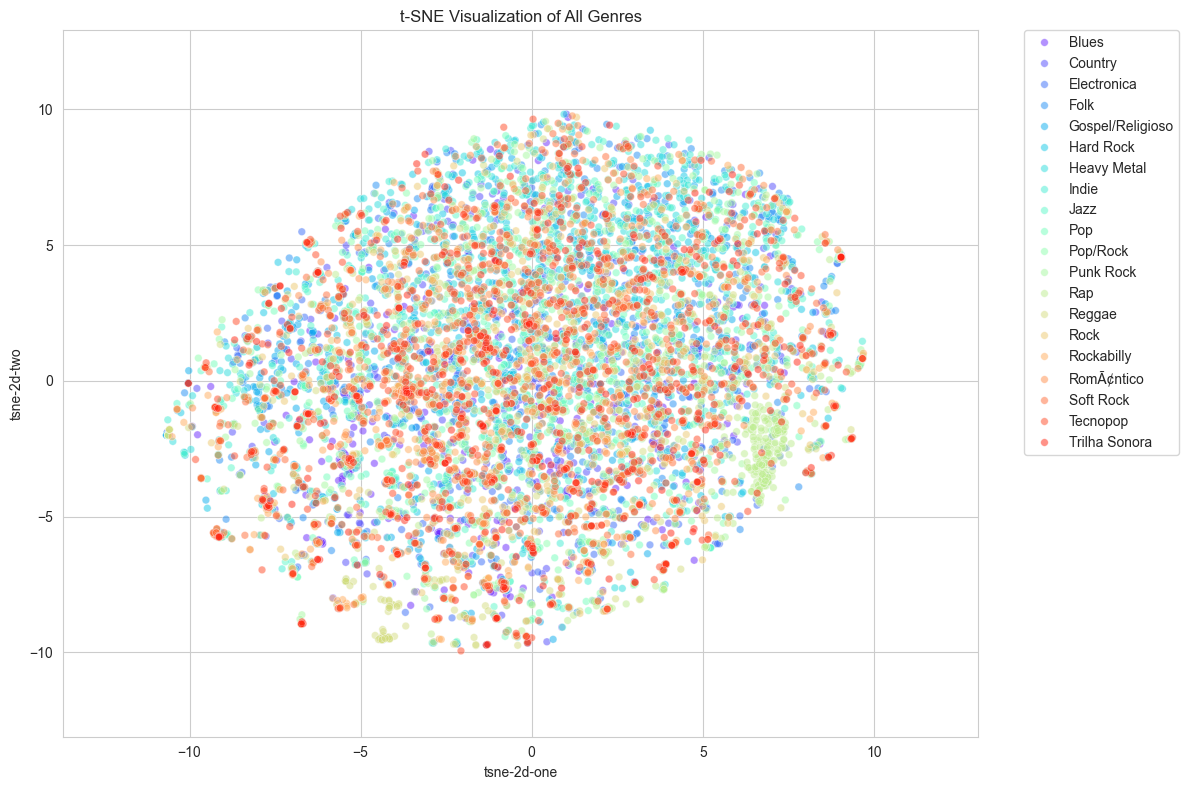

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.205s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.323396
[t-SNE] KL divergence after 50 iterations with early exaggeration: 74.250885
[t-SNE] KL divergence after 300 iterations: 2.166395


C:\Users\herbe\AppData\Local\Temp\ipykernel_2684\3201414745.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['tsne-2d-one'] = tsne_results[:,0]
C:\Users\herbe\AppData\Local\Temp\ipykernel_2684\3201414745.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['tsne-2d-two'] = tsne_results[:,1]


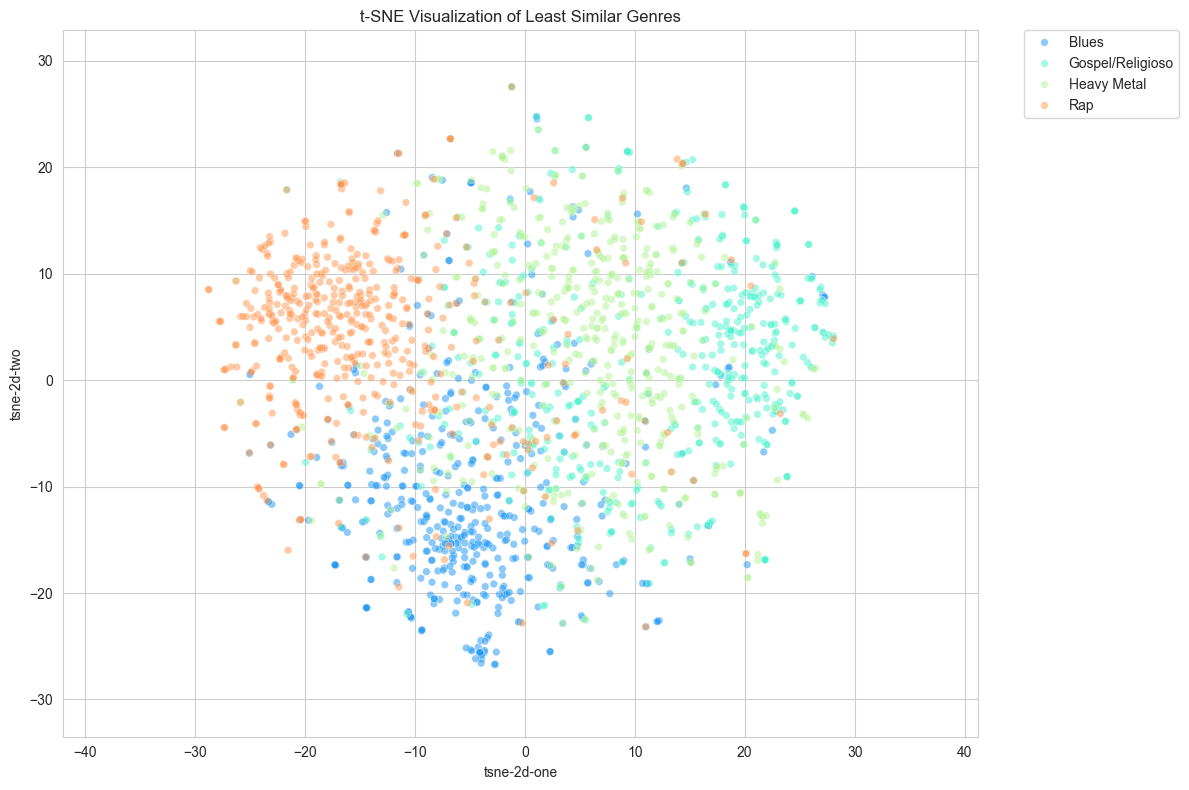

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.220s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.402119
[t-SNE] KL divergence after 250 iterations with early exaggeration: 111.705399
[t-SNE] KL divergence after 300 iterations: 5.776475


C:\Users\herbe\AppData\Local\Temp\ipykernel_2684\3201414745.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['tsne-2d-one'] = tsne_results[:,0]
C:\Users\herbe\AppData\Local\Temp\ipykernel_2684\3201414745.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['tsne-2d-two'] = tsne_results[:,1]


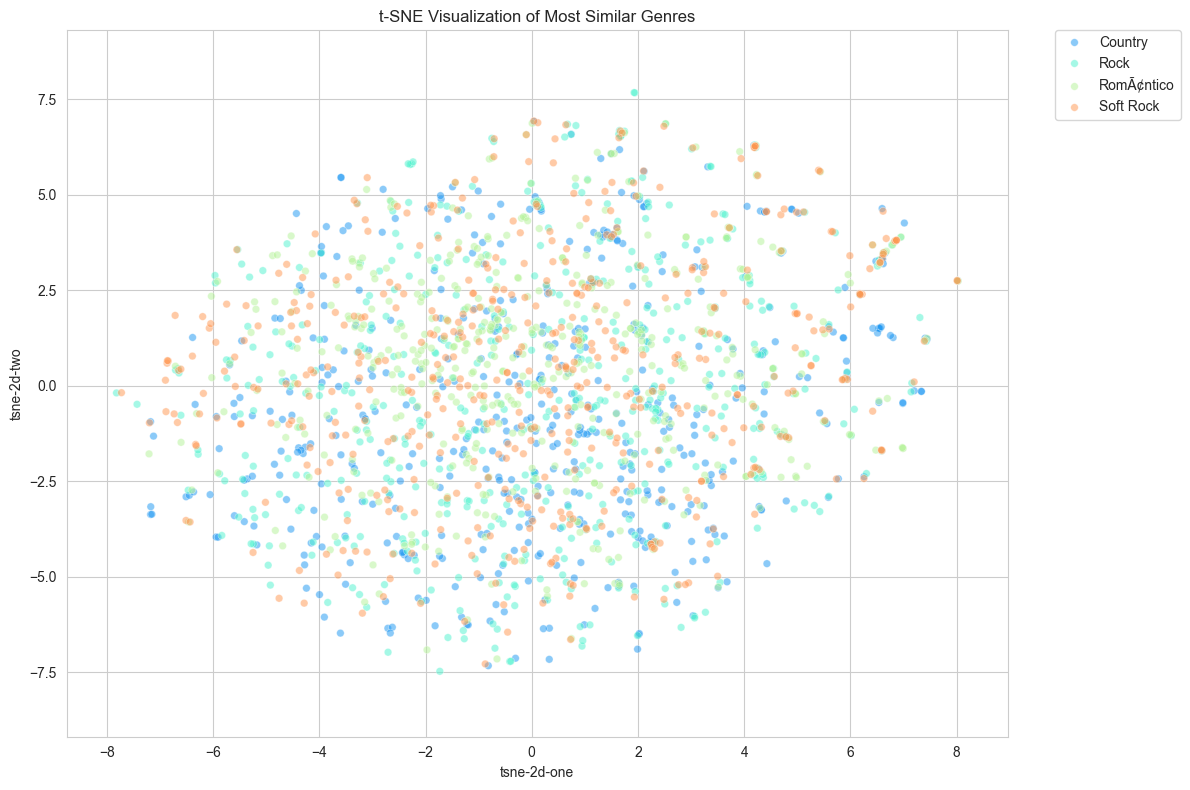

In [50]:
plot_tsne_for_genres(analysis_df, analysis_df['Genres'].unique(), "All Genres")
plot_tsne_for_genres(analysis_df, min_similarity_combo[0], "Least Similar Genres")
plot_tsne_for_genres(analysis_df, max_similarity_combo[0], "Most Similar Genres")


In [53]:
# Drop rows where the genre column is in the genres_to_drop list
min_similarity_df = load_df[load_df['Genres'].isin(min_similarity_combo[0])]
# Drop rows where the genre column is in the genres_to_drop list
max_similarity_df = load_df[load_df['Genres'].isin(max_similarity_combo[0])]
top_20_df = load_df[load_df['Genres'].isin(top_genres)]

print("Minimum Similarity DF")
# Now df_filtered contains only the rows where genre is not 'alternative', 'r&b', 'pop/rock', or 'rock'
print(min_similarity_df['Genres'].value_counts())

print("\nMaximum Similarity DF")
# Now df_filtered contains only the rows where genre is not 'alternative', 'r&b', 'pop/rock', or 'rock'
print(max_similarity_df['Genres'].value_counts())

Minimum Similarity DF
Genres
Heavy Metal         4394
Rap                 3124
Gospel/Religioso    1431
Blues               1063
Name: count, dtype: int64

Maximum Similarity DF
Genres
Country       4774
Rock          4672
Soft Rock     1003
RomÃ¢ntico     829
Name: count, dtype: int64


In [56]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
from imblearn.over_sampling import SMOTE
from textblob import TextBlob

# Ensure NLTK resources are downloaded
nltk.download('stopwords', quiet=True)

def remove_repetitions(text):
    words = text.split()
    return ' '.join(sorted(set(words), key=words.index))

def clean_lyrics(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    stop_words = set(stopwords.words('english'))
    return ' '.join(word for word in text.split() if word not in stop_words)

def get_sentiment(text):
    # Calculate sentiment polarity using TextBlob
    return TextBlob(text).sentiment.polarity

def train_genre_classifier(df, class_balance = True, print = True, title=""):
    if class_balance == True:
        genre_counts = df['Genres'].value_counts()
        smallest_size = genre_counts.min()
        df_sampled = df.groupby('Genres').sample(n = smallest_size, random_state=SEED)
    else:
        df_sampled = df

    # Conversion to string
    df_sampled.loc[:, 'Titel'] = df_sampled['Titel'].astype(str)
    df_sampled.loc[:, 'Lyric'] = df_sampled['Lyric'].astype(str)
    df_sampled.loc[:, 'Artist'] = df_sampled['Artist'].astype(str)

    # Clean lyrics and calculate sentiment
    df_sampled.loc[:, 'Lyric'] = df_sampled['Lyric'].apply(clean_lyrics)
    df_sampled.loc[:, 'sentiment'] = df_sampled['Lyric'].apply(get_sentiment)

    # Count the number of words in the 'Lyric' column and normalize
    df_sampled.loc[:, 'lyric_count'] = df_sampled['Lyric'].str.split().str.len()
    df_sampled.loc[:, 'lyric_count_norm'] = df_sampled['lyric_count'] / df_sampled['lyric_count'].max()

    # Encoding labels
    label_encoder = LabelEncoder()
    df_sampled.loc[:, 'label'] = label_encoder.fit_transform(df_sampled['Genres'])

    # Preprocessing and vectorization of text data
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    X_text = vectorizer.fit_transform(df_sampled['Lyric'])

    # Adding the normalized lyric count and sentiment as features
    X_numeric = df_sampled[['lyric_count_norm', 'sentiment']].values

    # Combining text and numeric features
    X_combined = hstack([X_text, X_numeric])
    # Labels
    y = df_sampled['Genres']

    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=SEED)

    # Apply SMOTE for class balancing in the training set
    smote = SMOTE(random_state=SEED)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Model training
    model = RandomForestClassifier(n_estimators=100, random_state=SEED)
    model.fit(X_train_resampled, y_train_resampled)
    
    # Model evaluation
        # Model evaluation
    predictions = model.predict(X_test)

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test, predictions)
    
    # Normalize the confusion matrix by row (i.e., by the number of true instances in each class)
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    # Plot normalized confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_normalized, annot=True, fmt=".0%", cmap='Blues', vmin=0, vmax=1, 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.ylabel('Actual Labels')
    plt.xlabel('Predicted Labels')
    plt.title(f'Relative Confusion Matrix {title}')
    plt.show()
    if print == True:

        print(classification_report(y_test, predictions))
        print(f'Accuracy: {accuracy_score(y_test, predictions):.2f}')

    return np.round(accuracy_score(y_test, predictions)*100,1)

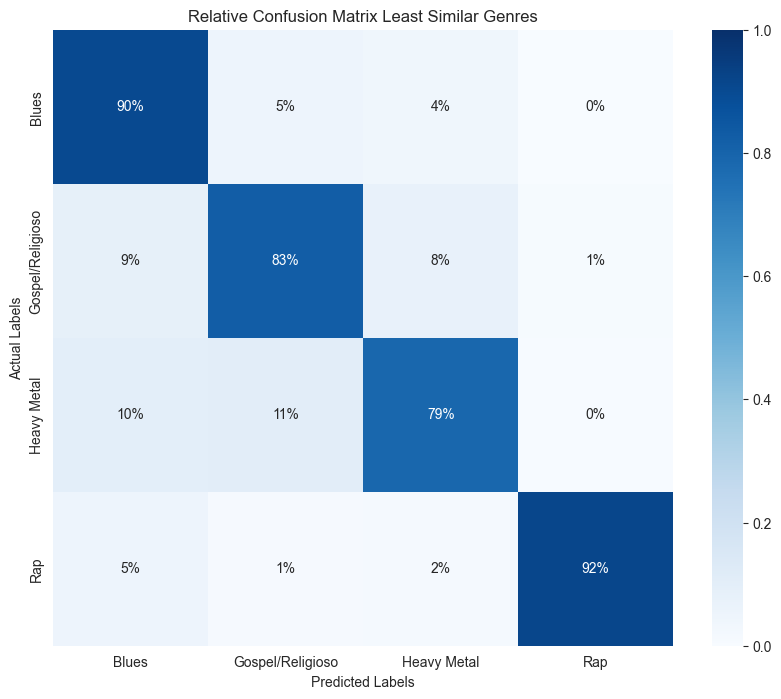

C:\Users\herbe\AppData\Local\Temp\ipykernel_2684\2064638211.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


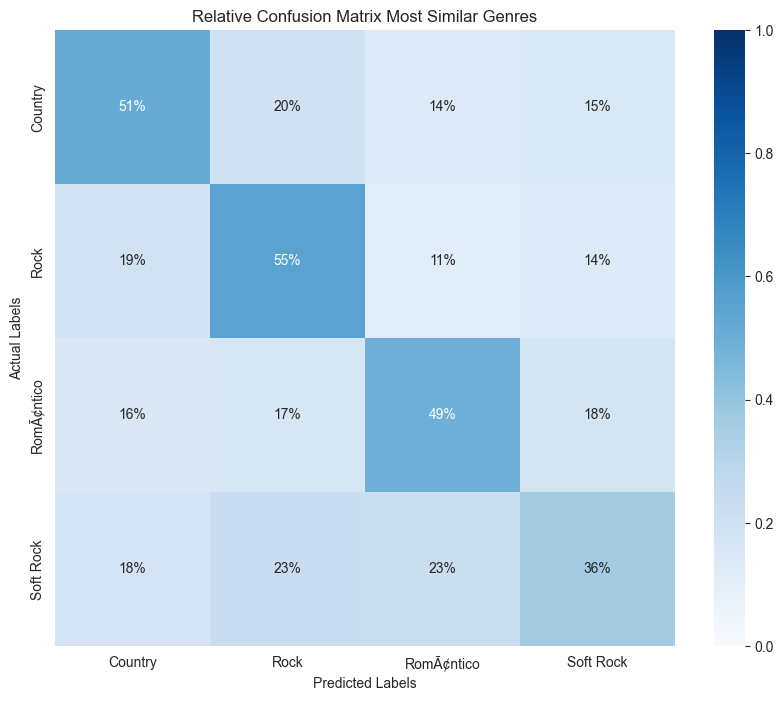

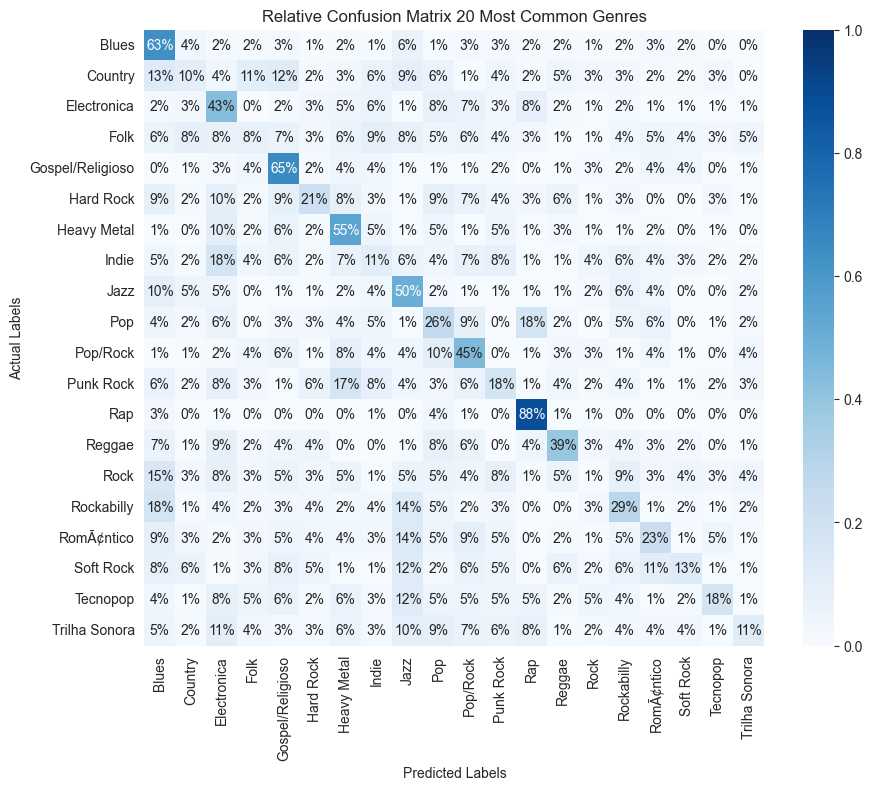

Accuracy Results:
                 Configuration  Accuracy
0  Min Similarity With Balance      85.8
1  Max Similarity With Balance      48.2
2  Max Similarity With Balance      32.3


In [57]:
# Initialize DataFrame to store results
results_df = pd.DataFrame(columns=['Configuration','Accuracy'])

def add_result(configuration, accuracy):
    global results_df
    new_row = pd.DataFrame({
        'Configuration': [configuration],
        'Accuracy': [accuracy]
    })
    results_df = pd.concat([results_df, new_row], ignore_index=True)

# Train and evaluate the classifier under different conditions
# add_result('Min Similarity No Balance', train_genre_classifier(min_similarity_df, class_balance=False, print = False))
# add_result('Max Similarity No Balance', train_genre_classifier(max_similarity_df, class_balance=False, print = False))
add_result('Min Similarity With Balance', train_genre_classifier(min_similarity_df, class_balance=True, print = False, title= "Least Similar Genres"))
add_result('Max Similarity With Balance', train_genre_classifier(max_similarity_df, class_balance=True, print = False, title= "Most Similar Genres"))
add_result('Max Similarity With Balance', train_genre_classifier(top_20_df, class_balance=True, print = False, title= "20 Most Common Genres"))

# Print results
print("Accuracy Results:")
print(results_df)
